#**Data Cleaning**


Pandas Pipeline
1.   Impor the data.
2.   Set the data types. (as function)
3.   Remove the outlier. (as function)





```
df.pipe(set_type).pipe(remove_out, min_row_country=10)
```



In [35]:
# Import libraries
import pandas as pd
import numpy as np


# This code is made to load our data stored on Google Drive
def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"

csv_names = ['products', 'orders', 'orderlines', 'brands']

# Google Drive file ids


files_id = {
    'products':"1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU",
    'orders':"1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ",
    'orderlines':"1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG",
    'brands':"1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD" 
} 

# Read data from Google Drive
products = pd.read_csv(gd_path(files_id['products']), sep=",")
orders = pd.read_csv(gd_path(files_id['orders']), sep=",")
orderlines = pd.read_csv(gd_path(files_id['orderlines']), sep=",")
brands = pd.read_csv(gd_path(files_id['brands']), sep=",")

In [36]:
# Display options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Functions

In [37]:
def start_pipeline(dataf):
    return dataf.copy()

def remove_dup(dataf):
    return dataf.drop_duplicates()

def check(df, operator, column_name, length_of_element):
  # Check if the operator is 'len' to indicate length check, otherwise assume dot count check
    if operator == len:  
        i = '.'  # Use '.' for length check
    else: 
        i = '\.'  # Use '\.' for dot count check
    return df[column_name].str.count(i).eq(length_of_element).sum()

def transform(df, column, new_column):    
  # Create a new column 'new_column' in the DataFrame 'df' to store the transformed values
    df[new_column] = (
    df[column].loc[df[column].notna() &
   (df[column].str.match(r'^\d{1,4}\.\d{1,3}$') | 
    df[column].str.match(r'^\d{1,5}$'))]
                .astype(float) # Convert the matched values to float data type
    .combine_first(df[column].loc[df[column].notna() &
                   df[column].str.match(r'^\d{3}\.\d{3}$')]
                             .astype(float) / 10) # Divide the matched values by 10
    .combine_first(df[column].loc[df[column].notna() &
                   df[column].str.match(r'^\d{1,3}\.\d{3}\.\d{3}$')]
                             .str.replace(".", "", regex=False) # Remove the dots from the matched values
                             .astype(float) / 100000) # Divide the matched values by 100000
)
    return df

def transform_OL(df, column, new_column):    # After analyzing the unti_price ORDERLINES, some new patterns were applied 
    df[new_column] = (
    df[column].loc[df[column].notna() &
   (df[column].str.match(r'^\d{1,4}\.\d{2}$'))]
              .astype(float)
    .combine_first(df[column].loc[df[column].notna() &
                   df[column].str.match(r'^\d{1,3}\.\d{3}\.\d{2}$')]
                             .str.replace(".", "", regex=False)
                             .astype(float)/100)
)
    return df


def analyze_prices(products_df, price_column):
  # Count and print the distribution of prices matching the pattern \d{1,3}\.\d{3}\.\d{3}
    case1_counts = (products_df[price_column].notna() & 
                    products_df[price_column].str.match(r'^\d{1,3}\.\d{3}\.\d{3}$')).value_counts(normalize=True)
    print("CASE 1: \d{1,3}\.\d{3}\.\d{3}")
    print(case1_counts)

    case2_counts = (products_df[price_column].notna() & 
                    products_df[price_column].str.match(r'^\d{3}\.\d{3}$')).value_counts(normalize=True)
    print("CASE 2: \d{3}\.\d{3}")
    print(case2_counts)

    case3_counts = (products_df[price_column].notna() & 
                    products_df[price_column].str.match(r'^\d{1,4}\.\d{1,3}$')).value_counts(normalize=True)
    print("CASE 3: \d{1,4}\.\d{1,3}")
    print(case3_counts)

    case4_counts = (products_df[price_column].notna() & 
                    products_df[price_column].str.match(r'^\d{1,5}$')).value_counts(normalize=True)
    print("CASE 4: \d{1,5}")
    print(case4_counts)
 
  # Count and print the distribution of missing (NA) prices
    na_counts = products_df[price_column].isna().value_counts(normalize=True)
    print("CASE Na")
    print(na_counts)


# 1 Products [non ok]

**products.csv**
* `sku` – stock keeping unit: a unique identifier for each product
* `name` – product name
* `desc` – product description
* `in_stock` – whether or not the product was in stock at the moment of the data extraction
* `type` – a numerical code for product type

In [38]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          19326 non-null  object
 1   name         19326 non-null  object
 2   desc         19319 non-null  object
 3   price        19280 non-null  object
 4   promo_price  19326 non-null  object
 5   in_stock     19326 non-null  int64 
 6   type         19276 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


### Preprocessing 
Check the size and drop duplicates.

In [39]:
products.nunique(), products.shape

(sku            10579
 name           10373
 desc            7098
 price           2690
 promo_price     4614
 in_stock           2
 type             126
 dtype: int64,
 (19326, 7))

In [40]:
products_1sp = products.pipe(start_pipeline).pipe(remove_dup)

#### **`price` analyses**

In [41]:
pd.set_option('display.max_colwidth', None) # Display full cell wight 

In [42]:
products_1sp[["name","price","promo_price"]].sample(5)

,name,price,promo_price
1872,Crucial Mac Memory 8GB 1866MHz DDR3 DIMM,115.99,1.159.894
12585,iFixit Piece Speaker iPhone 5s,19.95,18.991
10808,Housing Flex Elektro Tucano iPhone 6 / 6S Plus Transparent / Black,19.9,159.902
10036,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 8GB RAM | 512GB SSD | AMD Radeon R9 M390",2689,24.739.902
12790,iFixit iPad 2 Piece Battery,49.95,399.905


In [43]:
products_1sp[products_1sp.price == products_1sp.promo_price].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 60 to 19306
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          204 non-null    object
 1   name         204 non-null    object
 2   desc         203 non-null    object
 3   price        204 non-null    object
 4   promo_price  204 non-null    object
 5   in_stock     204 non-null    int64 
 6   type         200 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.8+ KB


In [44]:
products_1sp[products_1sp.price.str.count('.') != products_1sp.promo_price.str.count('.')].sample(5)

,sku,name,desc,price,promo_price,in_stock,type
18829,WAC0224-A,Wacom Intuos Pen & Touch 3D Creative Medium Black,Multitouch graphics tablet with ExpressKeys keys Reconditioned pencil precision and free 3D software for Mac and PC,199.99,1.612.866,0,1405
15055,LIF0119,Submersible Nood LifeProof iPhone Case 7 Black,waterproof and resistant to extreme conditions Case for iPhone 7,89.99,669.904,1,11865403
13523,BEL0283,Belkin Sport Armband Pro-Fit Bracelet Black iPhone 7,lightweight neoprene armband with reflective tape and large belt loop for iPhone 7,34.99,189.897,0,5405
12753,XDO0009-A,(Open) X-Doria Defense Housing Edge 38mm Apple Watch Gold,anti-shock housing for Apple Watch,24.99,164.942,0,1298
12733,PAC1470,OWC ThunderBay 4 Thunderbolt 2 Edition RAID 5 | 8TB Seagate Desktop,OWC ThunderBay 4 + 8TB (4x2TB) Seagate Hard Drives Desktop for Mac and PC,1061.95,8.263.683,0,11935397


In [45]:
# Investigate the cases
(
#CASE 1
    (products_1sp.price.notna() & 
     products_1sp.price.str.match(r'^\d{1,3}\.\d{3}\.\d{3}$'))
     .value_counts(normalize=True)
#CASE 2
   ,(products_1sp.price.notna() & 
      products_1sp.price.str.match(r'^\d{3}\.\d{3}$'))
     .value_counts(normalize=True)
#CASE 3
   ,(products_1sp.price.notna() & 
      products_1sp.price.str.match(r'^\d{1,4}\.\d{1,3}$'))  
     .value_counts(normalize=True)
#CASE 4
   ,(products_1sp.price.notna() & 
      products_1sp.price.str.match(r'^\d{1,5}$'))  
     .value_counts(normalize=True)
#Na
   ,products_1sp.price.isna().value_counts(normalize=True)
)

# code too function

(False   0.96
 True    0.04
 Name: price, dtype: float64,
 False   0.99
 True    0.01
 Name: price, dtype: float64,
 True    0.66
 False   0.34
 Name: price, dtype: float64,
 False   0.70
 True    0.30
 Name: price, dtype: float64,
 False   1.00
 True    0.00
 Name: price, dtype: float64)

In [46]:
analyze_prices(products_1sp, "price")

CASE 1: \d{1,3}\.\d{3}\.\d{3}
False   0.96
True    0.04
Name: price, dtype: float64
CASE 2: \d{3}\.\d{3}
False   0.99
True    0.01
Name: price, dtype: float64
CASE 3: \d{1,4}\.\d{1,3}
True    0.66
False   0.34
Name: price, dtype: float64
CASE 4: \d{1,5}
False   0.70
True    0.30
Name: price, dtype: float64
CASE Na
False   1.00
True    0.00
Name: price, dtype: float64


#### **Clean by cases**

The columns `price` and `prome_price` seem to have multiple mistakes. 

* The range of "." count is 0-2.
* The range of digits in a nummer 1-11.

```
CASE 1
- 352.559.394 (10)   >  remove "." , float / 10000
-  12.808.289 (138)  >  remove "." , float / 10000
-   6.999.003 (229)  >  remove "." , float / 10000
	
r'^\d{1,3}\.\d{3}\.\d{3}$'

CASE 2	
-     164.923 (139) > float / 10 

r'^\d{3}\.\d{3}$'

CASE 3
-      91.989 (23)  > float
-       9.082 (3)   > float

-     679.99 > float
-      79.99 > float
-       9.99 > float
 
-    2117.5 (35) > float
-     119.9 (113)> float 
-      19.9 (347)> float
-       9.9 (11) > float 
       sum: 6941

r'^\d{1,4}\.\d{1,3}$'

CASE 4
- 11019 (42)   > float
-  2859 (1132) > float
-   209 (1112) > float
-    35        > float
-     9        > float 
     sum:3215

r'^\d{1,5}$'

```


##### CASE 4 and CASE 3

In [47]:
(
    products_1sp.loc[products_1sp.price.notna() &
                     (products_1sp.price.str.match(r'^\d{1,4}\.\d{1,3}$') | 
                      products_1sp.price.str.match(r'^\d{1,5}$'))]["price"]
                                        .astype(float)
    .combine_first(products_1sp.loc[products_1sp.price.notna() &
                                    products_1sp.price.str.match(r'^\d{3}\.\d{3}$')]["price"]
                                                          .astype(float) / 10)
)

0       59.99
1       59.00
2       59.00
3       25.00
4       34.99
         ... 
19321   29.99
19322   69.95
19323   69.95
19324   69.95
19325   69.95
Name: price, Length: 10156, dtype: float64

##### CASE 2

In [48]:
(
products_1sp[products_1sp.price.notna() &
             products_1sp.price.str.match(r'^\d{3}\.\d{3}$')].price.sample(10)
                                                              .astype(float)/10
)

961     79.99
14744   34.99
15342   59.99
12127   49.99
15160   44.99
18672   34.99
999     10.99
15377   59.99
15417   39.99
12746   89.99
Name: price, dtype: float64

##### CASE 1

In [49]:
(
products_1sp[products_1sp.price.notna() &
             products_1sp.price.str.match(r'^\d{1,3}\.\d{3}\.\d{3}$')]
                         .price.str.replace(".","", regex=False)
                         .astype(float)/100000
).copy()   

(
products_1sp.isna().sum()
,products_1sp[["desc","price","type"]].isna().value_counts(normalize=True)
)

(sku             0
 name            0
 desc            7
 price          46
 promo_price     0
 in_stock        0
 type           50
 dtype: int64,
 desc   price  type 
 False  False  False   0.99
               True    0.00
        True   False   0.00
 True   False  False   0.00
 dtype: float64)

##### Apply all Cases

In [50]:
products_1sp["cl_price"] = (
products_1sp[products_1sp.price.notna() &
             products_1sp.price.str.match(r'^\d{1,4}\.\d{1,3}$')| 
             products_1sp.price.str.match(r'^\d{1,5}$')]
                         .price.astype(float)
.combine_first(products_1sp[products_1sp.price.notna() &
               products_1sp.price.str.match(r'^\d{3}\.\d{3}$')]
                           .price.astype(float)/10)
.combine_first(products_1sp[products_1sp.price.notna() &
             products_1sp.price.str.match(r'^\d{1,3}\.\d{3}\.\d{3}$')]
                         .price.str.replace(".","", regex=False)
                         .astype(float)/100000)
)
# As functions 

(count   10476.00
 mean      646.07
 std      1336.52
 min         2.99
 25%        44.95
 50%       109.99
 75%       601.32
 max     15339.00
 Name: cl_price, dtype: float64,
 <Axes: >)

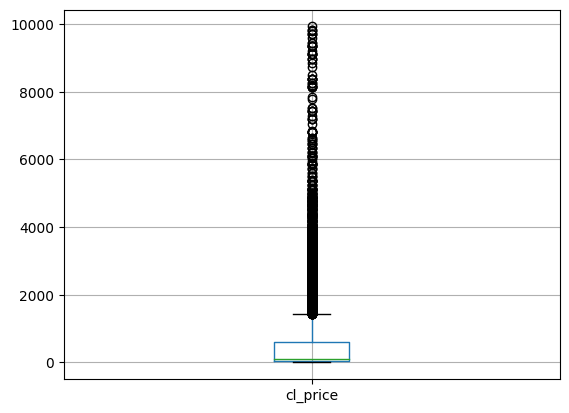

In [51]:
products_2sp = transform(products_1sp,'price','cl_price').dropna().copy()

(
products_2sp.cl_price.describe()
,products_2sp[products_2sp.cl_price < 10000].boxplot('cl_price')
)

####`promo_price`

In [52]:
products_2sp.promo_price

0        499.899
1        589.996
2        569.898
3        229.997
4          31.99
          ...   
19321    269.903
19322    649.903
19323    649.903
19324    649.903
19325    649.903
Name: promo_price, Length: 10476, dtype: object

In [53]:
# Investigate the cases
analyze_prices(products_1sp, "promo_price")

CASE 1: \d{1,3}\.\d{3}\.\d{3}
False   0.57
True    0.43
Name: promo_price, dtype: float64
CASE 2: \d{3}\.\d{3}
False   0.56
True    0.44
Name: promo_price, dtype: float64
CASE 3: \d{1,4}\.\d{1,3}
True    0.55
False   0.45
Name: promo_price, dtype: float64
CASE 4: \d{1,5}
False   0.99
True    0.01
Name: promo_price, dtype: float64
CASE Na
False   1.00
Name: promo_price, dtype: float64


Compare `price` to `promo_price` - is seemingly corrupted.
* 43% with X.xxx.xxx  
* 44% with xxx.xxx 

(count   10476.00
 mean      255.55
 std       299.21
 min         2.31
 25%        49.89
 50%       169.90
 75%       369.90
 max      9841.99
 Name: cl_promo_price, dtype: float64,
 <Axes: >)

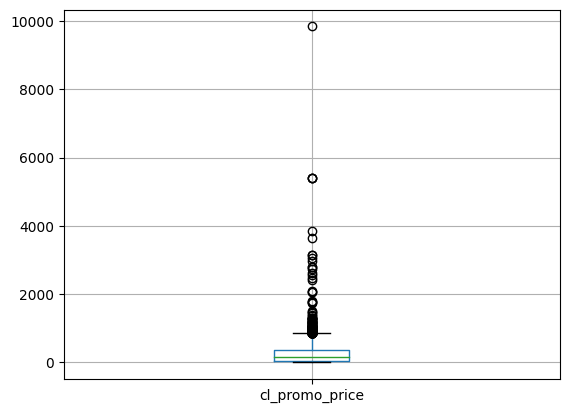

In [54]:
#Only testing the function
products_2sp = transform(products_1sp,'promo_price','cl_promo_price').dropna().copy()

(
products_2sp.cl_promo_price.describe()
,products_2sp[products_2sp.cl_promo_price > 1].boxplot('cl_promo_price')
)

####**`sku`**

In [55]:
products_2sp.sku

0        RAI0007
1        APP0023
2        APP0025
3        APP0072
4        KIN0007
          ...   
19321    BEL0376
19322    THU0060
19323    THU0061
19324    THU0062
19325    THU0063
Name: sku, Length: 10476, dtype: object

In [56]:
len(products_2sp.sku.unique())

10476

In [57]:
products_2sp[products_1sp.sku.str.slice(0,3) == "REP"].sort_values(by="desc").sample(2)

<ipython-input-57-0d7eca000b8f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  products_2sp[products_1sp.sku.str.slice(0,3) == "REP"].sort_values(by="desc").sample(2)


,sku,name,desc,price,promo_price,in_stock,type,cl_price,cl_promo_price
945,REP0193,posterior chamber repair cases 3,Installation service includes parts and labor for iPad 3,69.999,699.888,0,"1,44E+11",70.00,699.89
2405,REP0239,battery repair iPhone 6,Repair service including parts and labor for iPhone 6,59.99,399.893,0,"1,44E+11",59.99,399.89


In [58]:
products_2sp["brands"] = products_2sp.sku.str.slice(0,3)

products_3sp = (
products_2sp.merge(
    brands,
    how="inner", 
    left_on="brands", 
    right_on="short")
[["sku","long", "name", "desc", "price", "promo_price","cl_price","cl_promo_price", "type",]]
.copy()
)

### Comparing, checking for differences

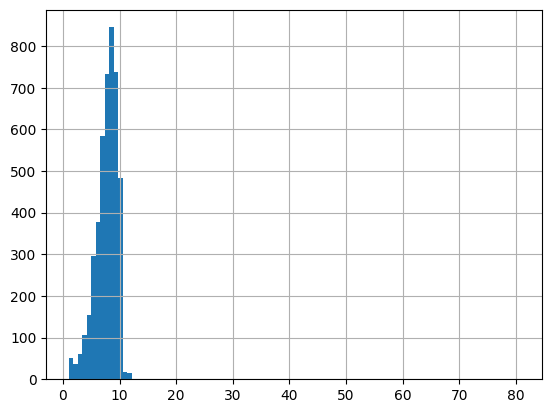

In [59]:
products_3sp['cl_deff'] = products_3sp.cl_price - products_3sp.cl_promo_price
products_3sp['cl_deff_2'] = products_3sp.cl_promo_price/products_3sp.cl_price
products_3sp[["price", "promo_price","cl_price","cl_promo_price","cl_deff","cl_deff_2"]]


products_3sp[products_3sp.cl_deff_2 > 1].cl_deff_2.hist(bins=100);

In [60]:
#Drop columns
#products_3sp = products_3sp.drop(["price","promo_price","cl_deff",'cl_deff_2'], axis=1)
products_3sp = products_3sp.drop(['cl_promo_price'], axis=1).dropna().copy()
products_3sp.sample(5)

,sku,long,name,desc,price,promo_price,cl_price,type,cl_deff,cl_deff_2
7819,GTE0100,G-Technology,G-Technology G-DRIVE HDD 6TB 7200rpm Thunderbolt 3 and USB-C,6TB hard drive with 2 USB 3 and Thunderbolt connections-C for Mac and PC.,475.99,3.459.947,475.99,11935397,441.39,0.07
9490,LEX0047,Lexar,Lexar Professional Workflow Disk 256GB External SSD,Portable SSD drive with 256GB USB 3.0 connection for Mac and PC,139.99,1.147.939,139.99,11935397,128.51,0.08
5537,PAC2361,Pack,Synology DS218 + NAS Server | 2GB RAM | 6TB (2x3TB) Seagate Iron Wolf,NAS storage server integrated with special focus on data protection,624.97,529.179,624.97,12175397,95.79,0.85
2599,GRT0430,Griffin,Griffin Survivor iPhone Case Clear 7 Clear,Resistant polycarbonate transparent cover for iPhone 7,24.99,129.894,24.99,11865403,-104.90,5.20
3907,WDT0285,Western Digital,Western Digital My Passport For Mac Black 2 TB hard drive for Mac,2TB External Hard Drive USB 3.0 for Mac.,109.99,999.896,109.99,11935397,-889.91,9.09


### Status
`promo_price` not OK

`type, name, desc, price`
keep, no cleaning required

Last Version: `products_3sp` 

# 2 Brands [ok]

**brands.csv**
* `short` – the 3-character code by which the brand can be identified in the first 3 characters of products.sku
* `long` – brand name

In [61]:
brands.sample(10)

,short,long
27,DJI,DJI
167,TPL,TP-Link
93,MOL,Moleskine
161,TAM,Tangram
95,MOS,Moshi
170,TRK,TrackR
185,ZAG,ZaggKeys
149,SOF,Software
104,NES,Nest
137,RUT,Runstastic


In [62]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   short   187 non-null    object
 1   long    187 non-null    object
dtypes: object(2)
memory usage: 3.0+ KB


### Status

All datatype are OK

Last Version: `brands` 

# 3 Orders [ok]


**orders.csv** – Every row in this file represents an order.
* `order_id` – a unique identifier for each order
* `created_date` – a timestamp for when the order was created
* `total_paid` – the total amount paid by the customer for this order, in euros
state 
 * “Shopping basket” – products have been placed in the shopping basket, but the order has not been processed yet.
 * “Pending” – the shopping basket has been processed, but payment confirmation is pending.
 * “Completed” – the order has been placed and paid, and the transaction is completed.
 * “Cancelled” – the order has been cancelled and the payment returned to the 
customer.

In [63]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


In [64]:
orders.sample(5)

,order_id,created_date,total_paid,state
84059,383634,2017-07-29 09:23:39,15.99,Shopping Basket
127484,427097,2017-11-15 12:12:32,138.42,Shopping Basket
125398,425011,2017-11-11 00:14:39,18.98,Completed
136045,435738,2017-11-23 20:23:40,100.76,Shopping Basket
145183,445278,2017-11-26 14:19:29,2122.98,Shopping Basket


In [65]:
orders.nunique()

order_id        226909
created_date    224828
total_paid       31236
state                5
dtype: int64

In [66]:
len(orders.order_id.unique())

226909

All `order_is` are unique.

In [67]:
orders_1sp = orders
orders_1sp["created_date"] = pd.to_datetime(orders.created_date).dropna().copy()

In [68]:
orders_1sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      226909 non-null  int64         
 1   created_date  226909 non-null  datetime64[ns]
 2   total_paid    226904 non-null  float64       
 3   state         226909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.9+ MB


In [69]:
orders_2sp_comp = orders_1sp[orders_1sp.state == "Completed"].dropna().copy()

In [70]:
orders_2sp_comp

,order_id,created_date,total_paid,state
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
5,245275,2017-06-28 11:35:37,149.00,Completed
6,245595,2017-01-21 12:52:47,112.97,Completed
...,...,...,...,...
226549,527042,2018-03-14 11:47:50,18.98,Completed
226577,527070,2018-03-14 11:50:48,24.97,Completed
226581,527074,2018-03-14 11:51:42,24.97,Completed
226603,527096,2018-03-14 11:58:40,34.96,Completed


### Status
All datatype are OK.
Price range is not OK

Clean version no filter: `orders_1sp` 
Last version with filter: `orders_2sp_comp` 

#4 Orderlines [non ok]

**orderlines.csv** – Every row represents each one of the different products involved in an order.
* `id` – a unique identifier for each row in this file
* `id_order` – corresponds to orders.order_id
* `product_id` – an old identifier for each product, nowadays not in use
* `product_quantity` – how many units of that product were purchased on that order
* `sku` – stock keeping unit: a unique identifier for each product
* `unit_price` – the unitary price (in euros) of each product at the moment of placing that order
date 
* `timestamp` for the processing of that product

In [71]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                293983 non-null  int64 
 1   id_order          293983 non-null  int64 
 2   product_id        293983 non-null  int64 
 3   product_quantity  293983 non-null  int64 
 4   sku               293983 non-null  object
 5   unit_price        293983 non-null  object
 6   date              293983 non-null  object
dtypes: int64(4), object(3)
memory usage: 15.7+ MB


###`unti_price` analyses

In [72]:
analyze_prices(orderlines,'unit_price')

CASE 1: \d{1,3}\.\d{3}\.\d{3}
False   1.00
Name: unit_price, dtype: float64
CASE 2: \d{3}\.\d{3}
False   1.00
Name: unit_price, dtype: float64
CASE 3: \d{1,4}\.\d{1,3}
True    0.88
False   0.12
Name: unit_price, dtype: float64
CASE 4: \d{1,5}
False   1.00
Name: unit_price, dtype: float64
CASE Na
False   1.00
Name: unit_price, dtype: float64


In [73]:
orderlines.unit_price.str.match(r'^\d+\.\d+\.\d+$').value_counts(normalize=True)
orderlines.unit_price.str.count(".").value_counts(normalize=True)
((orderlines.unit_price.str.endswith("0")) | (orderlines.unit_price.str.endswith("9"))).value_counts(normalize=True)

True    0.87
False   0.13
Name: unit_price, dtype: float64

In [74]:
orderlines[orderlines.unit_price.str.match(r'^\d+\.\d+\.\d{2}$')].sample(5)
orderlines[orderlines.unit_price.str.match(r'^\d{3}\.\d{2}$')].sample(5)

,id,id_order,product_id,product_quantity,sku,unit_price,date
117885,1354385,401026,0,1,APP0909,642.59,2017-09-17 18:17:42
17933,1160519,315296,0,1,SAM0074,164.99,2017-01-27 00:00:05
276940,1623401,515803,0,1,APP0662,159.00,2018-02-22 00:25:38
193157,1483790,457950,0,1,LAC0155,117.79,2017-12-09 01:03:30
123326,1364225,405810,0,1,APP2478,807.33,2017-09-28 13:09:37


In [75]:
orderlines[orderlines.unit_price.str.count(".") > 4].sample(5)

,id,id_order,product_id,product_quantity,sku,unit_price,date
168315,1447997,443861,0,2,OWC0063,17.84,2017-11-25 18:40:24
230433,1548400,486165,0,1,APP2157,849.00,2018-01-09 07:30:42
254276,1586591,500823,0,1,UBT0007,314.99,2018-01-29 10:30:58
222078,1534491,480557,0,1,APP2500,389.99,2018-01-03 08:47:54
78476,1271138,367176,0,1,SHE0039,29.99,2017-06-19 16:04:03


In [76]:
orderlines_1sp = transform_OL(orderlines,"unit_price","cl_unit_price").copy()

In [77]:
orderlines[orderlines['id_order'] == 461458], orders_1sp[orders_1sp['order_id'] == 461458]

(             id  id_order  product_id  product_quantity      sku unit_price  \
 199773  1492821    461458           0                 1  MIN0011      13.99   
 
                        date  cl_unit_price  
 199773  2017-12-13 07:37:44          13.99  ,
         order_id        created_date  total_paid            state
 161200    461458 2017-12-13 07:37:44       13.99  Shopping Basket)

* `orders`:`created_date` is the same as `orderlines`:`date`
 
* `orders`:`order_id` is the same as `orderlines`:`id_order`






In [78]:
orderlines_2sp = orderlines_1sp.copy()
orderlines_2sp["date"] = pd.to_datetime(orderlines.date)
orderlines_2sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                293983 non-null  int64         
 1   id_order          293983 non-null  int64         
 2   product_id        293983 non-null  int64         
 3   product_quantity  293983 non-null  int64         
 4   sku               293983 non-null  object        
 5   unit_price        293983 non-null  object        
 6   date              293983 non-null  datetime64[ns]
 7   cl_unit_price     293982 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 17.9+ MB


In [79]:
orderlines_2sp[orderlines_2sp.product_quantity ==2]
orderlines_2sp["sum_price"] = orderlines_1sp.product_quantity * orderlines_1sp.cl_unit_price
orderlines_2sp

,id,id_order,product_id,product_quantity,sku,unit_price,date,cl_unit_price,sum_price
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19,18.99,18.99
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45,399.00,399.00
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57,474.05,474.05
3,1119112,299542,0,1,WDT0315,68.39,2017-01-01 00:51:40,68.39,68.39
4,1119113,299543,0,1,JBL0104,23.74,2017-01-01 01:06:38,23.74,23.74
...,...,...,...,...,...,...,...,...,...
293978,1650199,527398,0,1,JBL0122,42.99,2018-03-14 13:57:25,42.99,42.99
293979,1650200,527399,0,1,PAC0653,141.58,2018-03-14 13:57:34,141.58,141.58
293980,1650201,527400,0,2,APP0698,9.99,2018-03-14 13:57:41,9.99,19.98
293981,1650202,527388,0,1,BEZ0204,19.99,2018-03-14 13:58:01,19.99,19.99


In [80]:
#Drop columns
orderlines_2sp = orderlines_2sp.drop(['unit_price'], axis=1).dropna().copy()
orderlines_2sp

,id,id_order,product_id,product_quantity,sku,date,cl_unit_price,sum_price
0,1119109,299539,0,1,OTT0133,2017-01-01 00:07:19,18.99,18.99
1,1119110,299540,0,1,LGE0043,2017-01-01 00:19:45,399.00,399.00
2,1119111,299541,0,1,PAR0071,2017-01-01 00:20:57,474.05,474.05
3,1119112,299542,0,1,WDT0315,2017-01-01 00:51:40,68.39,68.39
4,1119113,299543,0,1,JBL0104,2017-01-01 01:06:38,23.74,23.74
...,...,...,...,...,...,...,...,...
293978,1650199,527398,0,1,JBL0122,2018-03-14 13:57:25,42.99,42.99
293979,1650200,527399,0,1,PAC0653,2018-03-14 13:57:34,141.58,141.58
293980,1650201,527400,0,2,APP0698,2018-03-14 13:57:41,9.99,19.98
293981,1650202,527388,0,1,BEZ0204,2018-03-14 13:58:01,19.99,19.99


In [81]:
orderlines_2sp.id_order.nunique()

204855

Different ammount of unique `id_order`

`orders`: 226909
`orderlines`: 204855

In [82]:
orderlines_2sp.query('product_quantity == 1').id_order.nunique()

194780

In [83]:
orderlines_2sp.query('product_quantity != 1').id_order.nunique()

14734

REP is not in `orderlines`

In [84]:
orderlines_2sp.sku.isin(["REP"]).sum() 

0

### Status
All OK 

Last Version `orderlines_2sp`

# Combine Tables

The `products` table should be the primary reference for all the products being sold. It is likely that, during the Data Cleaning phase, you deleted many rows from `products`. Any order involving products not present there is susceptible to containing corrupted information.

You might choose to deal with this in many different ways, but a conservative one would be to delete all of the potentially corrupted rows. 

Exclude orders with unknown products.

`orderlines.sku` are in `produts.sku`. If `sku` not in `products` remove it from `orderlines.order_id` and from `orders`.  If no it will affect the Orders. 


### All clean Tables

In [85]:
orderlines_2sp.head(1).sort_values(by="id_order")

,id,id_order,product_id,product_quantity,sku,date,cl_unit_price,sum_price
0,1119109,299539,0,1,OTT0133,2017-01-01 00:07:19,18.99,18.99


In [86]:
products_3sp.sample(1)

,sku,long,name,desc,price,promo_price,cl_price,type,cl_deff,cl_deff_2
3437,SPE0205,Spek SeeThru,Presidio Speck Case iPhone X Black,protective case with anti-impact polycarbonate iPhone X,24.95,179.915,24.95,11865403,-154.97,7.21


In [87]:
orders_2sp_comp.sample(1)

,order_id,created_date,total_paid,state
150874,451075,2017-11-29 00:31:59,116.97,Completed


In [88]:
orderlines_in_prod = orderlines_2sp.merge(
    products_3sp,
    how = "left",
    left_on = 'sku',
    right_on = 'sku'
)

len(set(orderlines_in_prod.sku)), len(set(orderlines_2sp.sku))

(7951, 7951)

In [89]:
orderlines_in_prod.isna().sum() #NA from products

id                     0
id_order               0
product_id             0
product_quantity       0
sku                    0
date                   0
cl_unit_price          0
sum_price              0
long                2031
name                2031
desc                2031
price               2031
promo_price         2031
cl_price            2031
type                2031
cl_deff             2031
cl_deff_2           2031
dtype: int64

This `ska` and `id_order` are not in `produkts`.

In [90]:
orderlines_in_prod[orderlines_in_prod['type'].isna()].tail(5)

,id,id_order,product_id,product_quantity,sku,date,cl_unit_price,sum_price,long,name,desc,price,promo_price,cl_price,type,cl_deff,cl_deff_2
291956,1646559,525670,0,1,DOD0010,2018-03-11 22:54:41,21.99,21.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292160,1646897,523315,0,1,LUM0008,2018-03-12 11:07:33,59.99,59.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292193,1646975,525863,0,1,UBT0009,2018-03-12 12:03:31,159.95,159.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292355,1647280,526003,0,1,NET0028,2018-03-12 15:59:19,404.99,404.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293647,1649570,527099,0,2,CAL0010,2018-03-14 11:54:58,299.99,599.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
drop_ids = list(orderlines_in_prod[orderlines_in_prod['type'].isna()].id_order.drop_duplicates())

Remove no corresponding `id_orders` from `orderlines`

In [92]:
orderlines_3sp = orderlines_2sp.set_index("id_order").drop(drop_ids, axis=0).reset_index().copy()

In [93]:
orderlines_2sp.shape, orderlines_3sp.shape

((293982, 8), (289668, 8))

Remove no corresponding `order_id` from `orders`


In [94]:
# Convert drop_ids to a set for faster membership checking
drop_ids_set = set(drop_ids)

# Filter rows with existing index values
orders_3sp_comp = orders_2sp_comp.set_index("order_id").loc[lambda x: x.index.isin(drop_ids_set) == False].reset_index()
orders_3sp_comp

,order_id,created_date,total_paid,state
0,241423,2017-11-06 13:10:02,136.15,Completed
1,242832,2017-12-31 17:40:03,15.76,Completed
2,243330,2017-02-16 10:59:38,84.98,Completed
3,245275,2017-06-28 11:35:37,149.00,Completed
4,245595,2017-01-21 12:52:47,112.97,Completed
...,...,...,...,...
46157,527042,2018-03-14 11:47:50,18.98,Completed
46158,527070,2018-03-14 11:50:48,24.97,Completed
46159,527074,2018-03-14 11:51:42,24.97,Completed
46160,527096,2018-03-14 11:58:40,34.96,Completed


Remove the not corresponding `id_orders` from `orderlines`

In [95]:
orderlines_4sp = orders_3sp_comp.merge(orderlines_3sp, how="right", left_on='order_id', right_on="id_order")
orderlines_4sp = orderlines_4sp.dropna().drop(["order_id","created_date","total_paid","state"], axis=1).copy()
orderlines_4sp

,id_order,id,product_id,product_quantity,sku,date,cl_unit_price,sum_price
7,299545,1119116,0,1,OWC0100,2017-01-01 01:46:16,47.49,47.49
8,299546,1119119,0,1,IOT0014,2017-01-01 01:50:34,18.99,18.99
9,295347,1119120,0,1,APP0700,2017-01-01 01:54:11,72.19,72.19
11,299549,1119126,0,1,PAC0929,2017-01-01 02:07:42,2565.99,2565.99
18,299556,1119134,0,1,CRU0039-A,2017-01-01 02:20:14,60.90,60.90
...,...,...,...,...,...,...,...,...
289285,525664,1649474,0,1,TUC0207,2018-03-14 11:45:05,16.52,16.52
289302,527070,1649512,0,2,APP0698,2018-03-14 11:49:01,9.99,19.98
289307,527074,1649522,0,2,APP0698,2018-03-14 11:49:36,9.99,19.98
289330,527096,1649565,0,3,APP0698,2018-03-14 11:54:35,9.99,29.97


In [96]:
orderlines_4sp

,id_order,id,product_id,product_quantity,sku,date,cl_unit_price,sum_price
7,299545,1119116,0,1,OWC0100,2017-01-01 01:46:16,47.49,47.49
8,299546,1119119,0,1,IOT0014,2017-01-01 01:50:34,18.99,18.99
9,295347,1119120,0,1,APP0700,2017-01-01 01:54:11,72.19,72.19
11,299549,1119126,0,1,PAC0929,2017-01-01 02:07:42,2565.99,2565.99
18,299556,1119134,0,1,CRU0039-A,2017-01-01 02:20:14,60.90,60.90
...,...,...,...,...,...,...,...,...
289285,525664,1649474,0,1,TUC0207,2018-03-14 11:45:05,16.52,16.52
289302,527070,1649512,0,2,APP0698,2018-03-14 11:49:01,9.99,19.98
289307,527074,1649522,0,2,APP0698,2018-03-14 11:49:36,9.99,19.98
289330,527096,1649565,0,3,APP0698,2018-03-14 11:54:35,9.99,29.97


### Status

Last Version: `orderlines_4sp` and `orders_3sp_comp`

# Big table

In [97]:
all_commbine = (
orders_3sp_comp
 .merge(
    orderlines_1sp, 
    how = "inner", 
    left_on ="order_id", 
    right_on ="id_order")
 .merge(
    products_3sp, 
    how = "inner",
    left_on = "sku",
    right_on = "sku")
 .copy()
)

In [98]:
(
all_commbine[(all_commbine.product_quantity == 1)
           & (all_commbine.state == "Completed")
           & (all_commbine.total_paid > 100) 
           & (all_commbine.total_paid < 100000) ]
            [["total_paid", 
              'product_quantity',
              'cl_unit_price',
              'cl_price']]
              .sort_values(by="total_paid")
              .drop_duplicates()
).sample(10)

,total_paid,product_quantity,cl_unit_price,cl_price
31127,233.98,1,228.99,444.00
50911,931.99,1,931.99,976.80
47324,3690.58,1,3525.59,4639.00
27335,143.45,1,19.47,29.90
41945,403.47,1,66.49,69.99
43759,2843.57,1,94.99,99.95
56850,1069.64,1,703.07,756.25
31162,246.17,1,27.19,34.99
33387,1486.56,1,225.00,239.00
41171,338.43,1,297.79,419.00


# Save tables

In [99]:
from google.colab import files

orders_1sp.to_csv("orders_cl.csv", index=False)
files.download('orders_cl.csv')

orders_3sp_comp.to_csv("orders_fl.csv", index=False)
files.download("orders_fl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
orderlines_4sp.to_csv("orderslines_fl.csv", index=False)
files.download("orderslines_fl.csv")

orderlines_2sp.to_csv("orderslines_cl.csv", index=False)
files.download("orderslines_cl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [101]:
products_3sp.to_csv("products_cl.csv", index=False)
files.download("products_cl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>